In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix,precision_recall_curve,auc
from sklearn.model_selection import train_test_split
# Configuración del entorno: Importa librerías para análisis, visualización y herramientas de machine learning, incluyendo diversos modelos y métricas de clasificación.

In [ ]:
def get_metrics(y_test: pd.Series, y_predict: pd.Series, y_predict_proba: list) -> tuple:
        
        accuracy = round(accuracy_score(y_test, y_predict),4)
        precision = round(precision_score(y_test, y_predict),4)
        recall = round(recall_score(y_test, y_predict),4)
        f1score = round(f1_score(y_test, y_predict),4)
        precision_auc, recall_auc, thresholds = precision_recall_curve(y_test, y_predict_proba)
        pr_auc = round(auc(recall_auc, precision_auc),4)

        return accuracy,precision,recall,f1score,pr_auc
# Función auxiliar que calcula y retorna las principales métricas de rendimiento para un problema de clasificación binaria.   

In [ ]:
df = pd.read_csv('./datasets/dataset_diabetes.csv')
df.columns = [i.lower() for i in df.columns]
# Carga el dataset desde un archivo CSV y estandariza los nombres de las columnas a minúsculas para facilitar su manipulación.

In [ ]:
df['class'] = df['class'].apply(lambda x: x.strip())
df['gender'] = df['gender'].apply(lambda x: x.upper())
# Normaliza columnas de texto: elimina espacios en 'class' y estandariza 'gender' a mayúsculas para asegurar la consistencia de los datos.

### Creamos la variable objetivo, (binaria) de String a Valor Entero

In [ ]:
df['class'] = df['class'].apply(lambda x: x.replace('Y','1').replace('N','0').replace('P','0'))
df['class'] = df['class'].astype(int)
# Binarización de la variable objetivo: Se mapean las clases a 1 (diabético) y 0 (no diabético/prediabético) y se convierte la columna a tipo entero.

#### Distribucion de clases

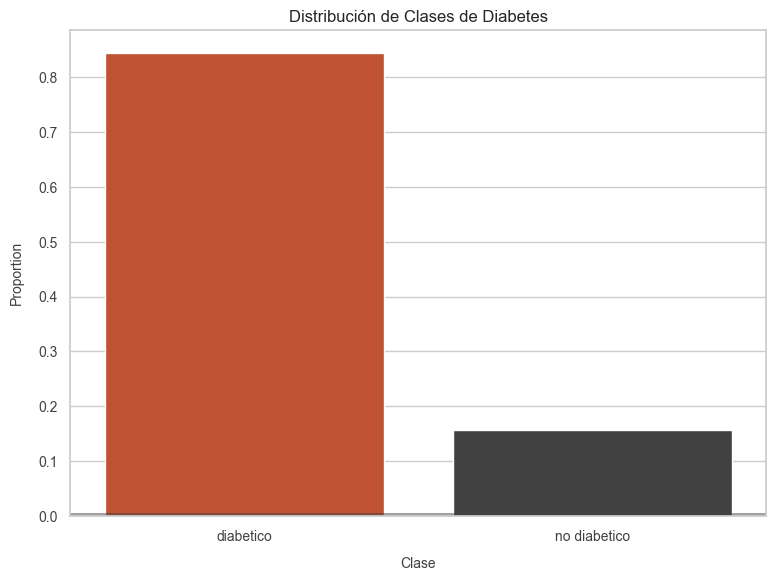

In [ ]:
palette = {
    'no diabetico': '#414141', 
    'diabetico': '#D5451B'   
}
df_ = df['class'].value_counts(normalize=True).to_frame().reset_index()
df_['class'] = df_['class'].apply(lambda x: str(x).replace('1','diabetico').replace('0','no diabetico'))
sns.set_theme(style="whitegrid")
# Configuración para la visualización: define una paleta de colores, calcula la proporción de cada clase y establece el estilo de los gráficos.

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='class', y='proportion', hue='class', data=df_, palette=palette)

# Personalizar el gráfico
plt.title('Distribución de Clases de Diabetes')
plt.xlabel('Clase', fontsize = 10, color = '#414141',labelpad = 10)
plt.ylabel('Proportion', fontsize = 10, color = '#414141',labelpad = 10)

plt.yticks( fontsize = 10, color = '#414141');
plt.xticks( fontsize = 10, color = '#414141');
plt.axhline(y = 0, color = '#414141', linewidth = 5, alpha = 0.5)

# Mostrar el gráfico
plt.show()

#### Volver la variable categorica `gender` a variable numerica, usando la tecnica: One Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['gender'], prefix='gender')
# Aplica codificación one-hot a la columna 'gender' para convertirla en variables numéricas que el modelo pueda procesar.


#### Split Entrenamiento y Validacion

In [ ]:
X = df.drop(columns = {'class'}, axis = 1)
y = df['class']
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 0, stratify=y)
# Preparación final de datos: separa las características (X) de la variable objetivo (y) y divide los datos en conjuntos de entrenamiento y prueba de forma estratificada.


#### Modeling

In [ ]:
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
xgb_model = XGBClassifier(random_state=42, verbosity=0)
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)
logreg_model = LogisticRegression(random_state=42)
# Inicialización de los modelos a comparar: se crean instancias de CatBoost, XGBoost, LightGBM y Regresión Logística con parámetros básicos para asegurar la reproducibilidad.

In [ ]:
MODELS = [catboost_model, xgb_model, lgbm_model, logreg_model]

model_results = []
for model in MODELS:
    model.fit(X_train, y_train);
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_predict = (y_pred_proba >= 0.5).astype(int) 
    accuracy,precision,recall,f1score, prauc = get_metrics(y_test = y_test, y_predict = y_predict, y_predict_proba = y_pred_proba)
    model_name = model.__class__.__name__
    metrics_dict = {
                'model_name' : model_name,
                'precision' : precision,
                'recall' : recall,
                'f1_score' : f1score,
                'pr_auc' : prauc
            }
    model_results.append(metrics_dict)
print(pd.DataFrame(model_results).to_markdown(index = False))
# Pipeline de evaluación: Itera sobre cada modelo para entrenarlo, evaluar su rendimiento en el set de prueba y presentar los resultados comparativos en una tabla.

| model_name         |   precision |   recall |   f1_score |   pr_auc |
|:-------------------|------------:|---------:|-----------:|---------:|
| CatBoostClassifier |      0.9922 |   1      |     0.9961 |   1      |
| XGBClassifier      |      0.9922 |   1      |     0.9961 |   1      |
| LGBMClassifier     |      0.9922 |   1      |     0.9961 |   1      |
| LogisticRegression |      0.8651 |   0.9881 |     0.9225 |   0.9354 |


#### Seleccionamos el modelo bajo el criterio del F1-Score

In [ ]:
best_model = lgbm_model
model.fit(X_train, y_train);
y_pred_proba = model.predict_proba(X_test)[:,1]
y_predict = (y_pred_proba >= 0.5).astype(int) 
# Selecciona el mejor modelo (LGBM) y genera un conjunto final de predicciones sobre los datos de prueba para un análisis más profundo.

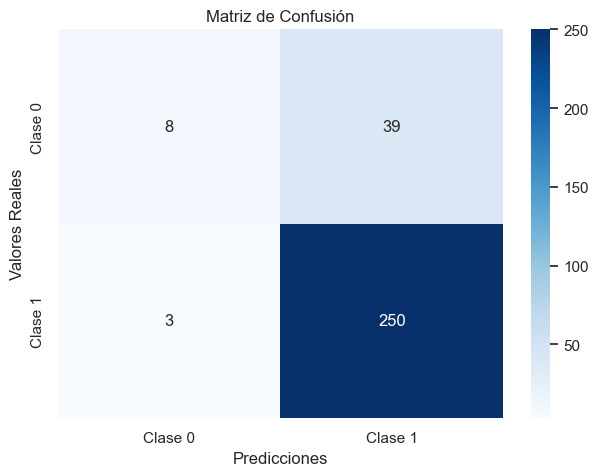

In [ ]:

cm = confusion_matrix(y_test, y_predict)

# Mostrar la matriz con Seaborn (opcional, pero visualmente útil)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()
# Calcula y visualiza la matriz de confusión para evaluar el rendimiento detallado del modelo, mostrando aciertos y errores de clasificación.

TP (True Positive): 8 (Clase 0 correctamente clasificada como Clase 0).

FN (False Negative): 3 (Clase 0 incorrectamente clasificada como Clase 1).

FP (False Positive): 39 (Clase 1 incorrectamente clasificada como Clase 0).

TN (True Negative): 250 (Clase 1 correctamente clasificada como Clase 1).

#### Feature Importance

In [ ]:
importance_df = pd.DataFrame({
    'feature': best_model.feature_name_,
    'importance': best_model.feature_importances_
})

importance_df['importance_pct'] = 100 * importance_df['importance'] / importance_df['importance'].sum()

importance_df = importance_df.sort_values(by='importance_pct', ascending=False).reset_index(drop=True)
importance_df
# Extrae, calcula y ordena la importancia de cada característica del mejor modelo para identificar los predictores más influyentes.

,feature,importance,importance_pct
0,hba1c,289,14.873906
1,no_pation,246,12.660834
2,chol,208,10.705095
3,id,201,10.344828
4,bmi,186,9.572826
5,age,160,8.234689
6,hdl,137,7.050952
7,ldl,124,6.381884
8,tg,117,6.021616
9,urea,100,5.146680


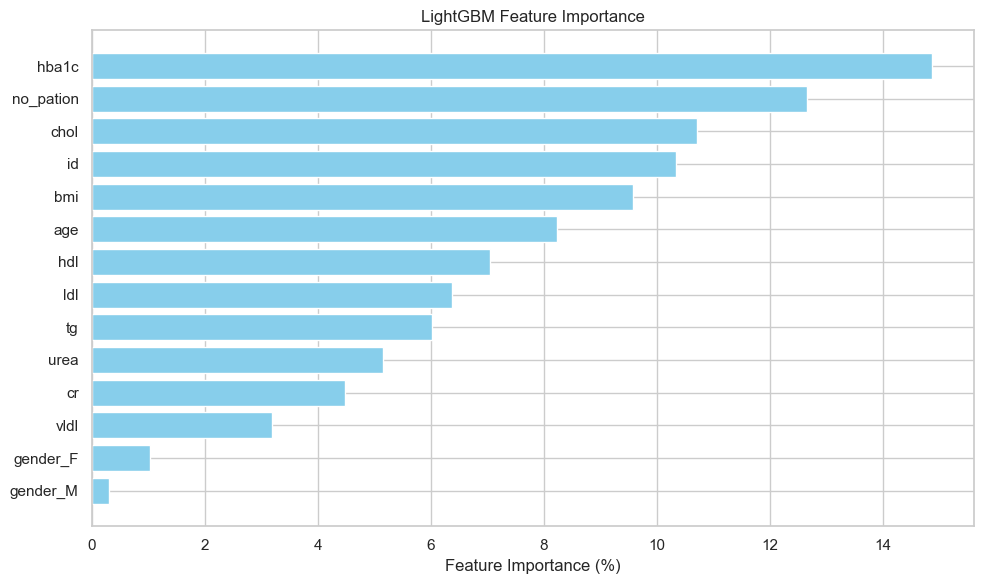

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance_pct'], color='skyblue')
plt.xlabel('Feature Importance (%)')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
# Crea un gráfico de barras horizontal para visualizar la importancia de cada característica, facilitando la interpretación de los resultados del modelo.